<a href="https://colab.research.google.com/github/SHANKHADEEP-CODES/Asset-Management-system/blob/main/dectect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stable Face Attentiveness Via Eye Tracking


--2024-03-10 05:17:59--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  38.8MB/s    in 1.6s    

2024-03-10 05:18:00 (38.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



<IPython.core.display.Javascript object>

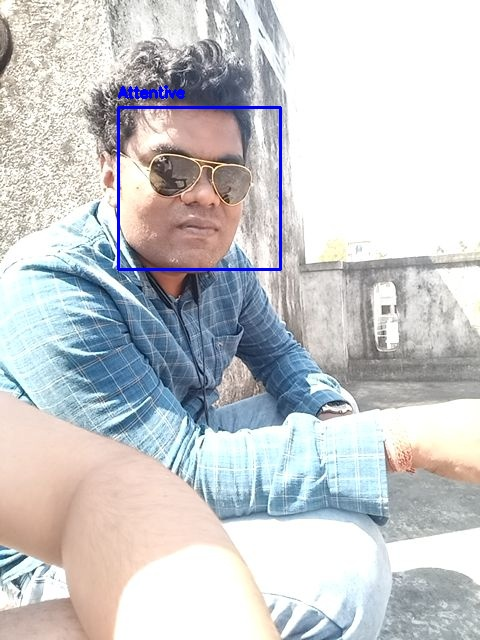

In [ ]:
# Import necessary libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import dlib
import io

# Download the shape_predictor_68_face_landmarks.dat file
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Initialize face cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the shape predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Function to convert JavaScript object into an OpenCV image
def js_to_image(js_reply):
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# Function to perform motion detection
def detect_motion(prev_frame, current_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference between frames
    frame_diff = cv2.absdiff(prev_gray, current_gray)

    # Apply threshold to identify regions with significant change
    _, threshold_diff = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw rectangles around the detected motion
    motion_bbox_array = np.zeros_like(current_frame)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        motion_bbox_array = cv2.rectangle(motion_bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return motion_bbox_array

def detect_attentiveness(face, shape):
    # Extract relevant facial landmarks for eye regions
    left_eye_points = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]
    right_eye_points = [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]

    # Calculate eye aspect ratio (EAR) for both eyes
    left_ear = eye_aspect_ratio(left_eye_points)
    right_ear = eye_aspect_ratio(right_eye_points)

    # Average eye aspect ratio
    ear = (left_ear + right_ear) / 2.0

    # Define a threshold for attentiveness
    attentiveness_threshold = 0.25  # Adjust this threshold as needed

    # Check if EAR is below the threshold (indicating closed eyes)
    attentiveness = ear > attentiveness_threshold

    return attentiveness



# Function to calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    # Calculate Euclidean distances between pairs of vertical/horizontal eye landmarks
    a = np.linalg.norm(np.array(eye[1]) - np.array(eye[5]))
    b = np.linalg.norm(np.array(eye[2]) - np.array(eye[4]))
    c = np.linalg.norm(np.array(eye[0]) - np.array(eye[3]))

    # Calculate eye aspect ratio
    ear = (a + b) / (2.0 * c)

    return ear

# Function to take photo with face detection, motion detection, and attentiveness check
def take_photo_with_attentiveness_alert(filename='photo.jpg', quality=0.8):
    # Initialize previous frame for motion detection
    prev_frame = None

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        function showAlert() {
            alert('Person is not attentive!');
        }
        ''')

    display(js)

    while True:
        # Get photo data
        data = eval_js('takePhoto({})'.format(quality))
        # Get OpenCV format image
        img = js_to_image(data)

        # Detect faces using Haar Cascade
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray)
        for (x, y, w, h) in faces:
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Detect facial landmarks
            shape = predictor(gray, dlib.rectangle(x, y, x + w, y + h))

            # Check attentiveness
            attentiveness = detect_attentiveness((x, y, w, h), shape)

            # Draw attentiveness status on the image
            attentiveness_text = "Attentive" if attentiveness else "Not Attentive"
            cv2.putText(img, attentiveness_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Show alert if not attentive
            if not attentiveness:
                eval_js('showAlert();')

        # Motion detection
        if prev_frame is not None:
            motion_bbox = detect_motion(prev_frame, img)
            img = cv2.addWeighted(img, 1, motion_bbox, 0.5, 0)

        # Save image
        cv2.imwrite(filename, img)

        # Update previous frame for the next iteration
        prev_frame = img.copy()

        # Display the image with face, motion detection, and attentiveness check
        display(Image(filename))

# Take photo with face, motion detection, and attentiveness check
try:
    take_photo_with_attentiveness_alert('photo_with_attentiveness_alert.jpg')
    print('Photo with face, motion detection, and attentiveness check saved successfully!')
except Exception as err:
    print(str(err))

In [ ]:
# Import necessary libraries
from IPython.display import display, Image
from base64 import b64decode
import cv2
import numpy as np
import dlib

# Download the shape_predictor_68_face_landmarks.dat file
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Initialize face cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the shape predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Function to convert base64-encoded image into an OpenCV image
def base64_to_image(base64_str):
    # Decode base64 image
    image_bytes = b64decode(base64_str)
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# Function to perform motion detection
def detect_motion(prev_frame, current_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference between frames
    frame_diff = cv2.absdiff(prev_gray, current_gray)

    # Apply threshold to identify regions with significant change
    _, threshold_diff = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw rectangles around the detected motion
    motion_bbox_array = np.zeros_like(current_frame)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        motion_bbox_array = cv2.rectangle(motion_bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return motion_bbox_array

# Function to detect attentiveness in an image
def detect_attentiveness(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Detect facial landmarks
        shape = predictor(gray, dlib.rectangle(x, y, x + w, y + h))

        # Check attentiveness
        attentiveness = detect_attentiveness_single((x, y, w, h), shape)

        # Draw attentiveness status on the image
        attentiveness_text = "Attentive" if attentiveness else "Not Attentive"
        cv2.putText(img, attentiveness_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return img

# Function to detect attentiveness for a single face
def detect_attentiveness_single(face, shape):
    # Extract relevant facial landmarks for eye regions
    left_eye_points = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]
    right_eye_points = [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]

    # Calculate eye aspect ratio (EAR) for both eyes
    left_ear = eye_aspect_ratio(left_eye_points)
    right_ear = eye_aspect_ratio(right_eye_points)

    # Average eye aspect ratio
    ear = (left_ear + right_ear) / 2.0

    # Define a threshold for attentiveness
    attentiveness_threshold = 0.25  # Adjust this threshold as needed

    # Check if EAR is below the threshold (indicating closed eyes)
    attentiveness = ear > attentiveness_threshold

    return attentiveness

# Function to calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    # Calculate Euclidean distances between pairs of vertical/horizontal eye landmarks
    a = np.linalg.norm(np.array(eye[1]) - np.array(eye[5]))
    b = np.linalg.norm(np.array(eye[2]) - np.array(eye[4]))
    c = np.linalg.norm(np.array(eye[0]) - np.array(eye[3]))

    # Calculate eye aspect ratio
    ear = (a + b) / (2.0 * c)

    return ear

# Function to take photo with face detection, motion detection, and attentiveness check
def process_image_and_detect_attentiveness(img_path, output_path='output.jpg'):
    # Read the locally uploaded image
    img = cv2.imread(img_path)

    # Initialize previous frame for motion detection
    prev_frame = None

    # Motion detection
    if prev_frame is not None:
        motion_bbox = detect_motion(prev_frame, img)
        img = cv2.addWeighted(img, 1, motion_bbox, 0.5, 0)

    # Detect attentiveness
    img_result = detect_attentiveness(img)

    # Save the output image
    cv2.imwrite(output_path, img_result)

    # Display the image with face, motion detection, and attentiveness check
    display(Image(output_path))

# Example: Process a locally uploaded image and detect attentiveness
image_path = '/Screenshot-_8_.jpeg'  # Specify the path to your image
output_image_path = 'output_8_.jpeg'

process_image_and_detect_attentiveness(image_path, output_image_path)


--2024-02-21 16:25:24--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.6MB/s    in 3.5s    

2024-02-21 16:25:27 (17.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
